## Problem Statement

According to the National Crime Records Bureau, nearly 24,012 people die each day due to a delay in getting medical assistance. Many accident victims wait for help at the site, and a delay costs them their lives. The reasons could range from ambulances stuck in traffic to the fire brigade not being able to reach the site on time due to traffic jams. 

The solution to the above problem is to create a system that automatically detects the emergency vehicle prior to reaching the traffic signals and change the traffic signals accordingly.

## Dataset

Download the dataset from [here](https://drive.google.com/file/d/1NChgxuJ7RzT0YPyP19S_-F0gsmEOiG64/view?usp=sharing)


## 1. Import Libraries

In [1]:
# for audio pre-processing and analysis:
import librosa as lib

# for audio features creation
import scipy

# for array processing:
import numpy as np

# for visualizing the data
from matplotlib import pyplot as plt
%matplotlib inline 

# for playing audio
import IPython.display as ipd

# for splitting data into train-test:
from sklearn.model_selection import train_test_split

# to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import * 

Using TensorFlow backend.


## 2. Load Audio Data

Using load function in librosa importing the audio files. The two audio clips contain multiple audio sounds recorded at different places.

In [2]:
# importing emergency file:
emergency, sample_rate = lib.load('audio/emergency.wav', sr=16000)

# importing non-emergency file:
non_emergency, sample_rate = lib.load('audio/non emergency.wav', sr=16000)

Remember, the audio waves are analogous and to convert the sounds into the digital i.e the binary and discrete signals, sampling process is applied. Therefore, the sample_rate (sr) of 16000 to read the above two audio clips. This sample rate means that 16000 is the average number of samples recorded per second.

### Finding the duration of the audio clips

Using the get_duration function

In [3]:
len1 = lib.get_duration(emergency, sr=16000)
len2 = lib.get_duration(non_emergency, sr=16000)

print('The duration of the Emergency clip is {} mins and Non-Emergency clip is {} mins.'.format(round(len1/60,2), round(len2/60,2)))

The duration of the Emergency clip is 22.92 mins and Non-Emergency clip is 27.16 mins.


## 3. Data Preparation -- Preparing the Audio Sequences

In this step, preparing the audio data into audio chunks. With the sound clip of 2 seconds length and the sampling rate of 16000 for each of the audio files, will have 32,000 samples.

In [4]:
# User-defined Function for Audio chunks audio data is the array

def audio_chunks(audio_data, num_of_samples=32000, sr=16000):
    
    # empty list to store new audio chunks formed 
    data=[]
    for i in range(0, len(audio_data), sr):
        
        # creating the audio chunk by starting with the first second & sliding the 2-second window one step at a time 
        chunk = audio_data[i: i+ num_of_samples]
        
        if(len(chunk)==32000):
            data.append(chunk)
    return data

Calling the above function audio_chunks to create seperate chunks for both Emergency and non-emergency vehicles:

In [5]:
# Prepare Audio Chunks
emergency = audio_chunks(emergency)
non_emergency = audio_chunks(non_emergency)

In [6]:
print('The number of chunks of Emergency is {} and Non-Emergency is {}.'.format(len(emergency), len(non_emergency)))

The number of chunks of Emergency is 1374 and Non-Emergency is 1628.


## 4. Playing the Audio Data

In [7]:
# Emergency Sound:
ipd.Audio(emergency[45], rate=16000)

In [8]:
# Non-Emergency Sound:
ipd.Audio(non_emergency[29], rate=16000)

## 5. Visualization of Audio Data

Visualizing the sounds waves in time domain

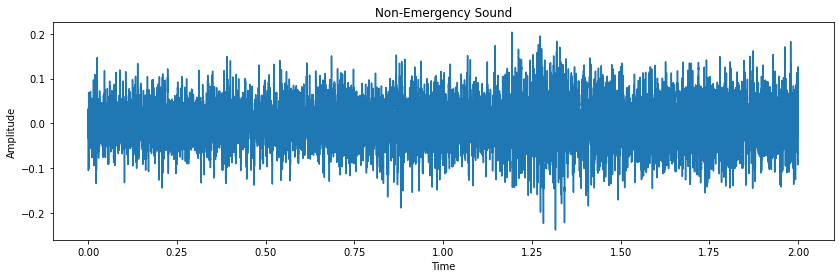

In [9]:
# Visualization:

# Non-Emergency Sound
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),non_emergency[33])
plt.title('Non-Emergency Sound')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

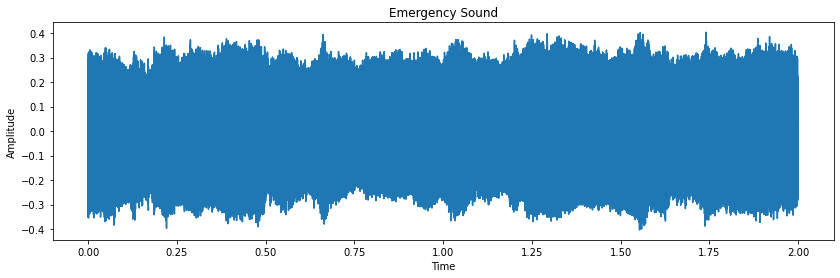

In [10]:
# Visualization:

# Emergency Sound
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),emergency[32])
plt.title('Emergency Sound')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

## 6. Split data into Train - Test 

Splitting the data into 80% train set and 20% testing set. 

In [11]:
# Step 1: Combining the Emergency and Non Emergency audio chunks
audio = np.concatenate([emergency,non_emergency])

# Step 2: Assigning labels 
labels1 = np.zeros(len(emergency))
labels2 = np.ones(len(non_emergency))

# concatenate labels
labels = np.concatenate([labels1,labels2])

In [12]:
print('The shape of the combined audio data is {}' .format(audio.shape))

The shape of the combined audio data is (3002, 32000)


In [13]:
# Train-test splitting:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(audio), np.array(labels), stratify=labels, test_size=0.20, 
                                                    random_state=12, shuffle=True)

print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('')
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (2401, 32000)
X_test (601, 32000)

Y_train (2401,)
Y_test (601,)


In [16]:
# Reshaping the 2-Dimensional array into 3-Dimensional array by setting the third dimension to 1:

X_train_features = X_train.reshape(len(X_train),-1,1)
X_test_features = X_test.reshape(len(X_test), -1,1)

print('The reshaped X_train array has size:', X_train_features.shape)
print('The reshaped X_test array has size:', X_test_features.shape)

The reshaped X_train array has size: (2401, 32000, 1)
The reshaped X_test array has size: (601, 32000, 1)


## Audio Classification Using Time Domain Features

## Model Architecture using CNN

Building the model using Conv1D and Time Domain features. Heres, using Functional APIs of Keras.

In [30]:
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *

In [48]:
def cnn_model(X_tr):
    
    inputs = Input(shape= (X_tr.shape[1], X_tr.shape[2]))
    
    # first Conv1D Layer with 8 filters of height 13:
    conv = Conv1D(8,13, padding='same', activation='relu')(inputs)
    conv = Dropout(0.3)(conv)
    conv = MaxPooling1D(2)(conv)
    
    # 2nd Conv1D Layer with 16 filters of height 11:
    conv = Conv1D(16,11, padding='same', activation='relu')(inputs)
    conv = Dropout(0.3)(conv)
    conv = MaxPooling1D(2)(conv)
    
    # Global MaxPooling 1D
    conv = GlobalMaxPool1D()(conv)
    
    # Dense Layer
    conv = Dense(16, activation='relu')(conv)
    outputs = Dense(1,activation='sigmoid')(conv)
    
    model = Model(inputs, outputs)
    
    # Model Compiler:
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['acc'])
    
    # Model Checkpoint
    model_checkpoint = ModelCheckpoint('best_model_cnn.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    
    return model, model_checkpoint

In [49]:
# Calling the model:
model, model_checkpoint = cnn_model(X_train_features)

In [44]:
# Shape and parameters at each layer
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 32000, 1)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 32000, 16)         192       
_________________________________________________________________
dropout_16 (Dropout)         (None, 32000, 16)         0         
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 16000, 16)         0         
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17  

Lets train the model for 10 epochs:

In [50]:
# model training
history = model.fit(X_train_features, Y_train ,epochs=10, callbacks=[model_checkpoint], batch_size=32, 
                    validation_data=(X_test_features, Y_test))

# accuracy for the model evaluation

Train on 2401 samples, validate on 601 samples
Epoch 1/10
2401/2401 [==============================] - 68s 28ms/step - loss: 0.6704 - acc: 0.5981 - val_loss: 0.6595 - val_acc: 0.6722

Epoch 00001: val_loss improved from inf to 0.65949, saving model to best_model_cnn.hdf5
Epoch 2/10
2401/2401 [==============================] - 76s 32ms/step - loss: 0.6279 - acc: 0.7393 - val_loss: 0.6269 - val_acc: 0.7621

Epoch 00002: val_loss improved from 0.65949 to 0.62686, saving model to best_model_cnn.hdf5
Epoch 3/10
2401/2401 [==============================] - 68s 28ms/step - loss: 0.5940 - acc: 0.7726 - val_loss: 0.6152 - val_acc: 0.6855

Epoch 00003: val_loss improved from 0.62686 to 0.61521, saving model to best_model_cnn.hdf5
Epoch 4/10
2401/2401 [==============================] - 64s 27ms/step - loss: 0.5760 - acc: 0.7693 - val_loss: 0.5953 - val_acc: 0.7471

Epoch 00004: val_loss improved from 0.61521 to 0.59530, saving model to best_model_cnn.hdf5
Epoch 5/10
2401/2401 [===================

In [51]:
# load the best model weights
model.load_weights('best_model_cnn.hdf5')

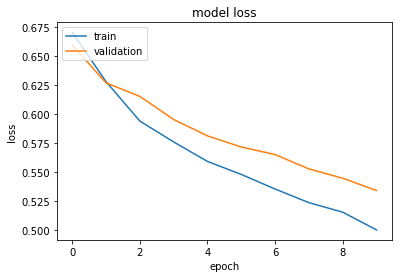

In [52]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Model Evaluation

In [53]:
# Checking the model's performance on the Test set

_, acc = model.evaluate(X_test_features, Y_test)
print("Validation Accuracy:",acc)

601/601 [==============================] - 4s 7ms/step
Validation Accuracy: 0.7703827023506165


## Prediction

In [55]:
# For Prediction: the input audio

index = 98
test_audio = X_test[index]

# Using IPython.display to play the audio
ipd.Audio(test_audio, rate=16000)

In [71]:
# classification

feature = X_test_features[index]

prob = model.predict(feature.reshape(1,-1,1))

if (prob[0][0] < 0.5):
    pred='emergency'
else:
    pred='non emergency' 

print("Prediction:",pred)

Prediction: non emergency


However, since the model accuracy is only 77% we can certainly improve on our model and therefore lets' try out another algorithm such as LSTM.

--------------------

## Model Architecture using LSTM Model

Let's define the model architecture using LSTM layers and the time domain features.

In [72]:
# Reshaping the Audio chunks:

X_train_features = X_train.reshape(len(X_train),-1,160)
X_test_features = X_test.reshape(len(X_test), -1,160)

print('The reshaped X_train array has size:', X_train_features.shape)
print('The reshaped X_test array has size:', X_test_features.shape)

The reshaped X_train array has size: (2401, 200, 160)
The reshaped X_test array has size: (601, 200, 160)


In [75]:
# LSTM based deep learning model architecture
def lstm_model(X_tr):
    
    inputs = Input(shape=(X_tr.shape[1], X_tr.shape[2]))
    
    # LSTM Layer 1
    x = LSTM(128)(inputs)
    x = Dropout(0.3)(x)
    
    # LSTM Layer 2
    x = LSTM(128)(inputs)
    x = Dropout(0.3)(x)
    
    # LSTM Layer 3
    x = LSTM(64)(inputs)
    x = Dropout(0.3)(x)
    
    # Dense Layer
    x = Dense(64, activation = 'relu')(x)
    x = Dense(1, activation = 'sigmoid')(x)
    
    model = Model(inputs, x)
    
    # Model compiler
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    
    # Model Checkpoint
    mc = ModelCheckpoint('best_model_lstm.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    
    return model, mc

In [77]:
# Calling the function
model, mc = lstm_model(X_train_features)


# Model Summary:
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 200, 160)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                57600     
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 61,825
Trainable params: 61,825
Non-trainable params: 0
_________________________________________________________________


In [79]:
# Training the model:

history=model.fit(X_train_features, Y_train, epochs=10, 
                  callbacks=[mc], batch_size=32,              # batch size + epochs : hyperparameters
                  validation_data=(X_test_features, Y_test))

Train on 2401 samples, validate on 601 samples
Epoch 1/10
2401/2401 [==============================] - 15s 6ms/step - loss: 0.6786 - acc: 0.5693 - val_loss: 0.6009 - val_acc: 0.7205

Epoch 00001: val_loss improved from inf to 0.60088, saving model to best_model_lstm.hdf5
Epoch 2/10
2401/2401 [==============================] - 15s 6ms/step - loss: 0.4492 - acc: 0.8105 - val_loss: 0.3669 - val_acc: 0.8369

Epoch 00002: val_loss improved from 0.60088 to 0.36692, saving model to best_model_lstm.hdf5
Epoch 3/10
2401/2401 [==============================] - 13s 6ms/step - loss: 0.3253 - acc: 0.8838 - val_loss: 0.3228 - val_acc: 0.8752

Epoch 00003: val_loss improved from 0.36692 to 0.32282, saving model to best_model_lstm.hdf5
Epoch 4/10
2401/2401 [==============================] - 15s 6ms/step - loss: 0.2625 - acc: 0.9063 - val_loss: 0.3762 - val_acc: 0.9085

Epoch 00004: val_loss did not improve from 0.32282
Epoch 5/10
2401/2401 [==============================] - 14s 6ms/step - loss: 0.2572

In [80]:
# load best model weights
model.load_weights('best_model_lstm.hdf5')

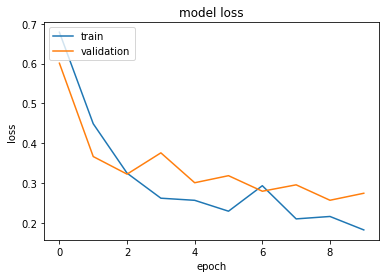

In [81]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [83]:
# Model Evaluation:

_,acc = model.evaluate(X_test_features, Y_test)
print("Accuracy:",acc)

601/601 [==============================] - 1s 2ms/step
Accuracy: 0.9134775400161743


## Prediction

In [84]:
# For Prediction using LSTM: the input audio

index = 513
test_audio = X_test[index]

# Using IPython.display to play the audio
ipd.Audio(test_audio, rate=16000)

In [86]:
# classification

feature = X_test_features[index]

prob = model.predict(feature.reshape(1,-1,160))

if (prob[0][0] < 0.5):
    pred='emergency'
else:
    pred='non emergency' 

print("Prediction:",pred)

Prediction: non emergency


Up until now, we built two types of model for audio classification, one using CNN and another using LSTM.

We got 71% accuracy with CNN model and 91% accuracy with LSTM model. We had used Time Domain features in both the models and going forward will use spectrogram features.

--------------------

## Spectrogram Features

Defining a function that computes the spectrogram for a given audio chunk

In [87]:
def spec_log(audio, sample_rate, eps = 1e-10):
    
    freq, times, spec = scipy.signal.spectrogram(audio, fs= sample_rate, nperseg=320, noverlap=160)
    return freq, times, np.log(spec.T.astype(np.float32) + eps)

Defining a function for showing the spectrogram:

In [88]:
# For Visualization of the Spectrogram:

def spec_plot(spectrogram, label):
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(211)
    ax.imshow(spectrogram.T, aspect='auto', extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax.set_title('Spectrogram of '+label)
    ax.set_xlabel('Seconds')
    ax.set_ylabel('Freqs in Hz')
    plt.show()

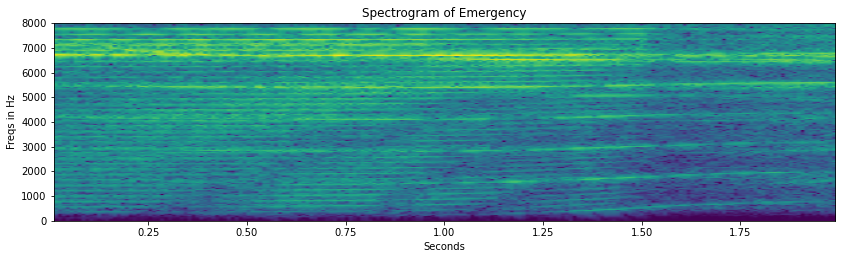

In [92]:
# Computing and Visualizing the Spectrogram for Emergency:

freqs, times, spectrogram = spec_log(emergency[162], sample_rate)
spec_plot(spectrogram,"Emergency")

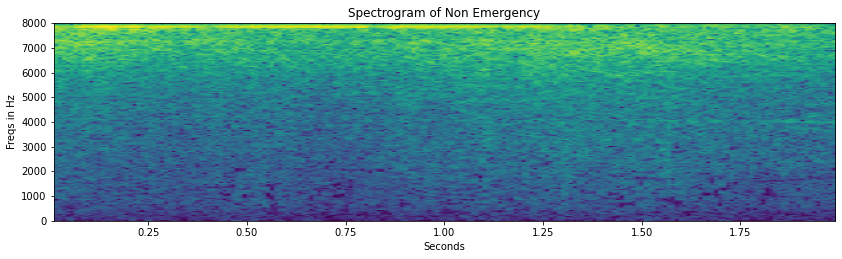

In [93]:
# Computing and Visualizing the Spectrogram for Non-Emergency:
freqs, times, spectrogram = spec_log(non_emergency[162], sample_rate)
spec_plot(spectrogram,"Non Emergency")

In non-emergency vehicle's spectrogram, no horizontal lines are depicted. This could be due to the absence of siren sound.

In [94]:
spectrogram.shape

(199, 161)

## Extract the spectrogram features

Extract the spectrogram features from the same audio set that we used above during the time domain features.

In [98]:
def extract_spec_features(X_tr):
    
    # defining empty list to store the features:
    features = []
    
    # We only need the 3rd array of Spectrogram so assigning the first two arrays as _
    for i in X_tr:
        _,_, spectrogram = spec_log(i, sample_rate)

        mean = np.mean(spectrogram, axis=0)
        std = np.std(spectrogram, axis=0)
        spectrogram = (spectrogram - mean)/std

        features.append(spectrogram)
    
    # returning the features as array
    return np.array(features)

In [99]:
# Calling extract function to get training and testing sets:

X_train_features = extract_spec_features(X_train)
X_test_features = extract_spec_features(X_test)

### Calling the CNN Model

In [101]:
model_3, modelcheckpoint_3 = cnn_model(X_train_features)

In [102]:
model_3.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 199, 161)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 199, 16)           28352     
_________________________________________________________________
dropout_29 (Dropout)         (None, 199, 16)           0         
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 99, 16)            0         
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 16)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 17 

In [104]:
# Model Training:
history=model_3.fit(X_train_features, Y_train, epochs=10, callbacks=[modelcheckpoint_3], batch_size=32, 
                    validation_data=(X_test_features, Y_test))

Train on 2401 samples, validate on 601 samples
Epoch 1/10
2401/2401 [==============================] - 6s 2ms/step - loss: 0.4650 - acc: 0.7880 - val_loss: 0.3585 - val_acc: 0.8469

Epoch 00001: val_loss improved from inf to 0.35845, saving model to best_model_cnn.hdf5
Epoch 2/10
2401/2401 [==============================] - 5s 2ms/step - loss: 0.1626 - acc: 0.9600 - val_loss: 0.2313 - val_acc: 0.9418

Epoch 00002: val_loss improved from 0.35845 to 0.23135, saving model to best_model_cnn.hdf5
Epoch 3/10
2401/2401 [==============================] - 5s 2ms/step - loss: 0.0696 - acc: 0.9921 - val_loss: 0.1743 - val_acc: 0.9601

Epoch 00003: val_loss improved from 0.23135 to 0.17430, saving model to best_model_cnn.hdf5
Epoch 4/10
2401/2401 [==============================] - 4s 2ms/step - loss: 0.0372 - acc: 0.9975 - val_loss: 0.1423 - val_acc: 0.9667

Epoch 00004: val_loss improved from 0.17430 to 0.14230, saving model to best_model_cnn.hdf5
Epoch 5/10
2401/2401 [===========================

Load the best saved model

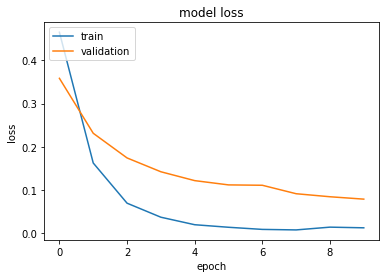

In [105]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [107]:
# model's performance on the test set:
_,acc = model_3.evaluate(X_test_features, Y_test)
print("Accuracy:",acc)

601/601 [==============================] - 0s 400us/step
Accuracy: 0.9700499176979065


## Calling the LSTM Model

In [112]:
model_2, mc_2 = lstm_model(X_train_features)

In [113]:
# Number of parameters and shape of each layer:
model_2.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 199, 161)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                57856     
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 62,081
Trainable params: 62,081
Non-trainable params: 0
_________________________________________________________________


In [115]:
# Train the model
history=model_2.fit(X_train_features, Y_train, epochs=10, callbacks=[mc_2], batch_size=32, 
                    validation_data=(X_test_features, Y_test))

Train on 2401 samples, validate on 601 samples
Epoch 1/10
2401/2401 [==============================] - 11s 5ms/step - loss: 0.6754 - acc: 0.5877 - val_loss: 0.6421 - val_acc: 0.6539

Epoch 00001: val_loss improved from inf to 0.64214, saving model to best_model_lstm.hdf5
Epoch 2/10
2401/2401 [==============================] - 11s 4ms/step - loss: 0.5549 - acc: 0.7509 - val_loss: 0.5130 - val_acc: 0.7687

Epoch 00002: val_loss improved from 0.64214 to 0.51300, saving model to best_model_lstm.hdf5
Epoch 3/10
2401/2401 [==============================] - 10s 4ms/step - loss: 0.3530 - acc: 0.8613 - val_loss: 0.6368 - val_acc: 0.7737

Epoch 00003: val_loss did not improve from 0.51300
Epoch 4/10
2401/2401 [==============================] - 12s 5ms/step - loss: 0.2294 - acc: 0.9221 - val_loss: 0.3511 - val_acc: 0.8686

Epoch 00004: val_loss improved from 0.51300 to 0.35111, saving model to best_model_lstm.hdf5
Epoch 5/10
2401/2401 [==============================] - 11s 5ms/step - loss: 0.2338

Load the weights of the best model:

In [116]:
model_2.load_weights('best_model_lstm.hdf5')

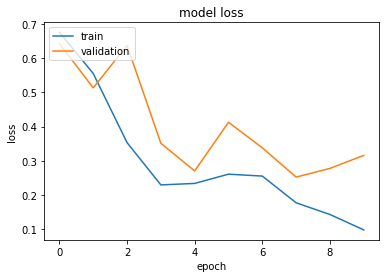

In [117]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Model Evaluation

Evaluating the performance of the model on the test set:

In [119]:
_,acc = model_2.evaluate(X_test_features, Y_test)
print("Accuracy:",acc)

601/601 [==============================] - 1s 1ms/step
Accuracy: 0.9051580429077148


-----------------